In [1]:
pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 40.3 MB/s eta 0:00:00


In [2]:
!pip install pytorch-lightning torchview torchvision torchinfo torchmetrics torch > /dev/null


In [3]:
import torch
import pytorch_lightning as pl

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    accelerator = 'cuda'
else:
    print("CUDA is not available. Falling back to CPU.")
    accelerator = 'cpu'

trainer = pl.Trainer(
    max_epochs=5,
    accelerator=accelerator,
    devices=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


CUDA is available. Using GPU.


DOWNLOADING DATA

---



In [4]:
import os
import tarfile
import urllib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import models
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, Subset
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import Accuracy, Precision, F1Score, ConfusionMatrix


# Function to download and extract the dataset
def download_and_extract_dataset(dataset_url, dataset_path, tar_file_path):
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path, exist_ok=True)
        print(f"Downloading the dataset from {dataset_url}...")
        urllib.request.urlretrieve(dataset_url, tar_file_path)
        print("Download complete!")
        print("Extracting the dataset...")
        with tarfile.open(tar_file_path, 'r') as tar_ref:
            tar_ref.extractall(path=dataset_path)
        print("Extraction complete!")
    else:
        print("Dataset already downloaded and extracted.")

# Data Preparation
dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
dataset_path = "data/images"
tar_file_path = "data/images.tar"
download_and_extract_dataset(dataset_url, dataset_path, tar_file_path)

# Define the augmentation and transformation steps
augmentations = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset from the 'Images' directory and apply the transformations
images_dir = os.path.join(dataset_path, 'Images')
dataset = ImageFolder(root=images_dir, transform=augmentations)

# Split the dataset into a train and validation set
targets = [label for _, label in dataset.samples]
train_idx, val_idx = train_test_split(
    range(len(targets)),
    test_size=0.2,  # 20% for validation
    random_state=42,  # Seed for reproducibility
    stratify=targets
)

# Create Subset objects to be used as the train and validation datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# Create DataLoaders for the train and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
class_names = dataset.classes

Download complete!
Extracting the dataset...
Extraction complete!


MODEL DEFINATION

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 182MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Loss: 4.8427324295043945, Accuracy: 0.0, F1 Score: 0.0, Precision: 0.0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Loss: 0.7245668768882751, Accuracy: 0.782069981098175, F1 Score: 0.7757095098495483, Precision: 0.8130995035171509


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Loss: 0.6927497982978821, Accuracy: 0.7842565774917603, F1 Score: 0.7789466381072998, Precision: 0.811762273311615


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Loss: 0.7085501551628113, Accuracy: 0.7920311093330383, F1 Score: 0.788467526435852, Precision: 0.8242297768592834
Validation Accuracy List: [0.0, 0.782069981098175, 0.7842565774917603, 0.7920311093330383]


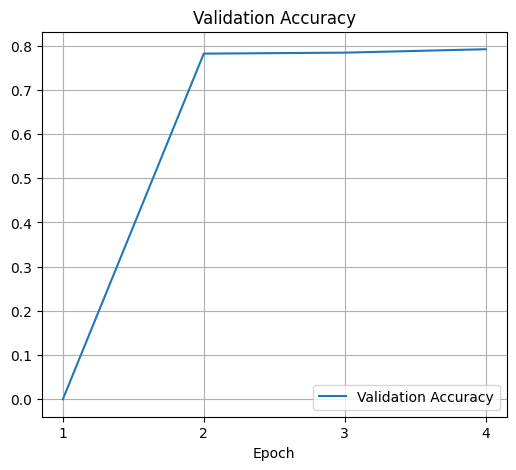

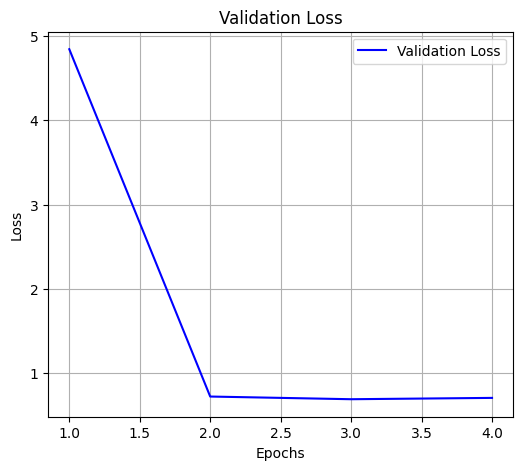

In [5]:
class DogBreedClassifier(pl.LightningModule):
    def __init__(self, num_classes=120):
        super().__init__()
        # Initialize the DenseNet model with the final layer adapted for 120 classes
        self.model = models.densenet161(weights=models.DenseNet161_Weights.IMAGENET1K_V1)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

        # Freeze the pretrained layers
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Define loss function and metrics
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(num_classes=num_classes, task = "multiclass")
        self.val_acc = Accuracy(num_classes=num_classes, task = "multiclass")
        self.f1 = F1Score(num_classes=num_classes, task = "multiclass", average='macro')
        self.precision = Precision(num_classes=num_classes, task = "multiclass", average='macro')
        self.confmat = ConfusionMatrix(num_classes=num_classes, task = "multiclass")
        self.confmat_matrices = []  # To store confusion matrices after each epoch

        # Variables to track validation metrics for each epoch
        self.validation_outputs = []  # To store outputs for the on_validation_epoch_end hook
        self.validation_loss_list = []
        self.validation_acc_list = []
        self.validation_f1_list = []
        self.validation_precision_list = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Calculate metrics manually
        correct = preds.eq(y).sum().item()
        total = y.size(0)
        manual_acc = correct / total

        # Update metrics
        self.val_acc.update(preds, y)
        self.f1.update(preds, y)
        self.precision.update(preds, y)
         # Update confusion matrix
        self.confmat.update(preds, y)


        # Store the outputs for use in the on_validation_epoch_end hook
        self.validation_outputs.append({'val_loss': loss.detach(), 'preds': preds, 'targets': y})
        return {'val_loss': loss.detach()}

    def on_validation_epoch_end(self):
        # Calculate the average of the validation loss using stored outputs
        if self.validation_outputs:
            avg_val_loss = torch.stack([x['val_loss'] for x in self.validation_outputs]).mean()
            avg_val_acc = self.val_acc.compute()
            avg_val_f1 = self.f1.compute()
            avg_val_precision = self.precision.compute()

            # Append the average metrics to the tracking lists
            self.validation_loss_list.append(avg_val_loss.cpu().item())
            self.validation_acc_list.append(avg_val_acc.cpu().item())
            self.validation_f1_list.append(avg_val_f1.cpu().item())
            self.validation_precision_list.append(avg_val_precision.cpu().item())

            # Print the validation metrics
            print(f'Epoch {self.current_epoch + 1}: '
                  f'Validation Loss: {avg_val_loss}, '
                  f'Accuracy: {avg_val_acc}, '
                  f'F1 Score: {avg_val_f1}, '
                  f'Precision: {avg_val_precision}')

            # Log the validation metrics
            self.log('avg_val_loss', avg_val_loss)
            self.log('avg_val_acc', avg_val_acc)
            self.log('avg_val_f1', avg_val_f1)
            self.log('avg_val_precision', avg_val_precision)

            # Compute and store the confusion matrix for the current epoch
            confmat = self.confmat.compute()
            self.confmat_matrices.append(confmat.cpu().numpy())
            self.confmat.reset()

            # Reset metrics after each epoch
            self.val_acc.reset()
            self.f1.reset()
            self.precision.reset()

            # Clear the list of saved outputs for the next epoch
            self.validation_outputs.clear()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)
        return optimizer

# Instantiate the model and trainer with CSVLogger
model = DogBreedClassifier(num_classes=120)
csv_logger = CSVLogger(save_dir='logs/', name='dog_breed_classifier_logs')
'''trainer = Trainer(
    max_epochs=2,
    logger=csv_logger,
    callbacks=[ModelCheckpoint(monitor='avg_val_loss'), EarlyStopping(monitor='avg_val_loss', patience=1)]
)'''
trainer = Trainer(
    max_epochs=4,  # Reduced for quicker runs
    logger=csv_logger,
    callbacks=[
        ModelCheckpoint(monitor='avg_val_loss'),
        EarlyStopping(monitor='avg_val_loss', patience=1)  # Early stopping after 1 stagnant epoch
    ],
    accelerator=accelerator,  # MPS or CPU
    devices=1  # Use a single device
)



# Assuming 'train_dataloader' and 'val_dataloader' are defined
try:
    trainer.fit(model, train_dataloader, val_dataloader)
except Exception as e:
    print(f"An error occurred during training: {e}")

torch.save(model.state_dict(), 'dog_breed_classifier.pth')

torch.save(model, 'dog_breed_classifier_full.pth')

#print("Validation Loss List:", model.validation_loss_list)
print("Validation Accuracy List:", model.validation_acc_list)

epochs = list(range(1, len(model.validation_loss_list) + 1))
plt.figure(figsize=(6, 5))
plt.plot(epochs, model.validation_acc_list, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

# Plot for loss
plt.figure(figsize=(6, 5))
plt.plot(epochs, model.validation_loss_list, 'b-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


Normalization Factors


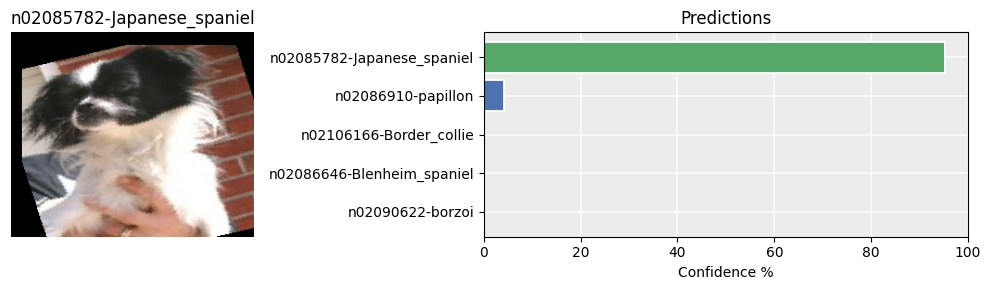

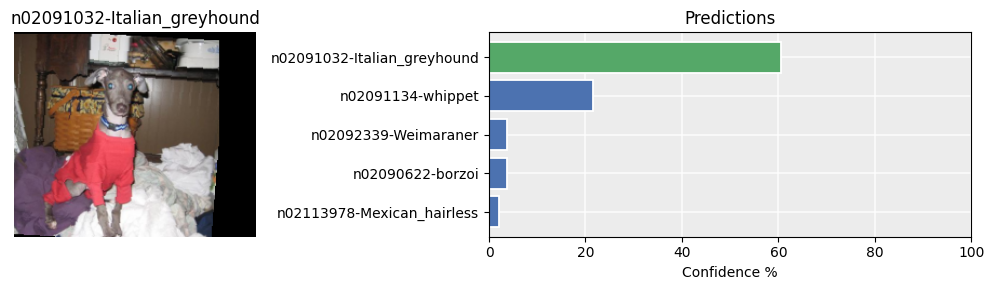

In [6]:
# Normalization factors used in your dataset
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])


class_names = dataset.classes  # This will give you the list of class names

def show_prediction(img, label, pred, K=5):
    # Convert normalization factors to numpy arrays
    norm_mean = NORM_MEAN.numpy()
    norm_std = NORM_STD.numpy()

    if isinstance(img, torch.Tensor):
        # Convert image to numpy array and normalize
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * norm_std) + norm_mean
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Create a figure with a 1x2 grid layout
    fig = plt.figure(figsize=(10, 3))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    # Display the image
    #ax0.imshow(img)
    ax0.imshow(img, aspect='auto')
    ax0.set_title(f'{class_names[label]}')
    ax0.axis('off')

    # Compute the softmax probabilities and find the top K predictions
    pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()

    # Assign colors to the bars based on the correct label
    colors = ['#55A868' if i == label else '#4C72B0' for i in topk_idx]

    # Plot the top K predictions with their confidence percentages
    ax1.barh(np.arange(K), topk_vals * 100, color=colors, edgecolor='white', linewidth=1.3)
    ax1.set_yticks(np.arange(K))
    ax1.set_yticklabels([class_names[i] for i in topk_idx])
    ax1.invert_yaxis()  # Highest probabilities on top
    ax1.set_xlabel('Confidence %')
    ax1.set_xlim(0, 100)
    ax1.set_title('Predictions')
    # Set the background to a grid
    ax1.set_facecolor('#ECECEC')  # Light grey background
    # Add gridlines and put them behind the bars
    ax1.xaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
    ax1.yaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
    ax1.set_axisbelow(True)  # This line ensures the grid is behind the plot

    plt.tight_layout()
    plt.show()


# Check if a GPU is available and set PyTorch to use the GPU, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Now, move your model to the selected device
model.to(device)

# The rest of your code can stay the same
model.eval()
exmp_batch, label_batch = next(iter(val_dataloader))
with torch.no_grad():
    preds = model(exmp_batch.to(device))

# Visualize predictions for the first few images in the batch
for i in range(min(len(exmp_batch), 2)):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])


Adversarial Attack Techniques and Visualization - Normalization Factor




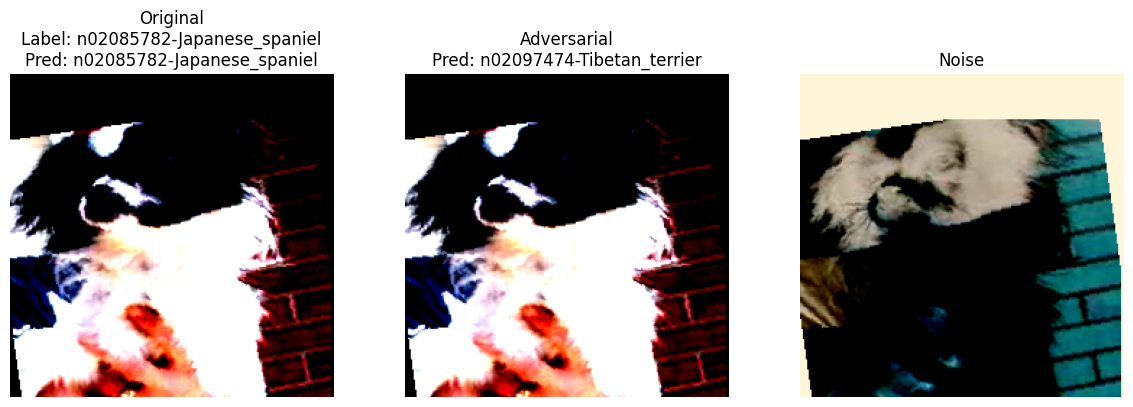

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def deepfool_attack(image, model, num_classes=10, overshoot=0.02, max_iter=50):
    """
    Perform the DeepFool attack to generate adversarial examples.
    """
    model.eval()
    image = image.unsqueeze(0).clone().detach().requires_grad_(True).to(next(model.parameters()).device)
    output = model(image)
    _, pred = torch.max(output, 1)
    original_label = pred.item()
    perturbation = torch.zeros_like(image).to(next(model.parameters()).device)

    for _ in range(max_iter):
        output = model(image + perturbation)
        probs = torch.softmax(output, dim=1)
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        if sorted_indices[0][0].item() != original_label:
            break
        grad_orig = torch.autograd.grad(output[0, original_label], image, retain_graph=True)[0]
        perturbation_direction = None
        min_perturbation = np.inf
        for k in range(1, num_classes):
            grad_other = torch.autograd.grad(output[0, sorted_indices[0][k]], image, retain_graph=True)[0]
            direction = grad_other - grad_orig
            delta = (output[0, sorted_indices[0][k]] - output[0, original_label]).abs() / direction.norm()
            if delta < min_perturbation:
                min_perturbation = delta
                perturbation_direction = direction
        perturbation += (min_perturbation + overshoot) * perturbation_direction / perturbation_direction.norm()

    adv_image = torch.clamp(image + perturbation, 0, 1).detach()
    return adv_image.squeeze(0), perturbation.squeeze(0)

def visualize_deepfool_attack(model, dataloader, class_names, device):
    """
    Visualize real and adversarial images with noise and predictions.
    """
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        original_image = images[0]
        original_label = labels[0].item()

        # Generate adversarial example
        adv_image, perturbation = deepfool_attack(original_image, model)

        # Get predictions for original and adversarial images
        original_pred = torch.argmax(model(original_image.unsqueeze(0))).item()
        adv_pred = torch.argmax(model(adv_image.unsqueeze(0))).item()

        # Visualize original, adversarial, and noise
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # Original image
        axes[0].imshow(original_image.permute(1, 2, 0).cpu().numpy())
        axes[0].set_title(f"Original\nLabel: {class_names[original_label]}\nPred: {class_names[original_pred]}")
        axes[0].axis("off")

        # Adversarial image
        axes[1].imshow(adv_image.permute(1, 2, 0).cpu().numpy())
        axes[1].set_title(f"Adversarial\nPred: {class_names[adv_pred]}")
        axes[1].axis("off")

        # Noise
        noise = (adv_image - original_image).permute(1, 2, 0).cpu().numpy()
        axes[2].imshow(noise / noise.max())
        axes[2].set_title("Noise")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()
        break  # Visualize only the first image

# Example usage
# Assuming 'model', 'test_loader', 'class_names', and 'device' are already defined
#visualize_deepfool_attack(model, val_dataloader, )

# Check if a GPU is available and set PyTorch to use the GPU, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)
visualize_deepfool_attack(model, val_dataloader, class_names, device)


DOING Adversarial Attack Techniques and Visualization - Normalization Factor AGAIN


<ipython-input-7-c1adcf0c2471>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


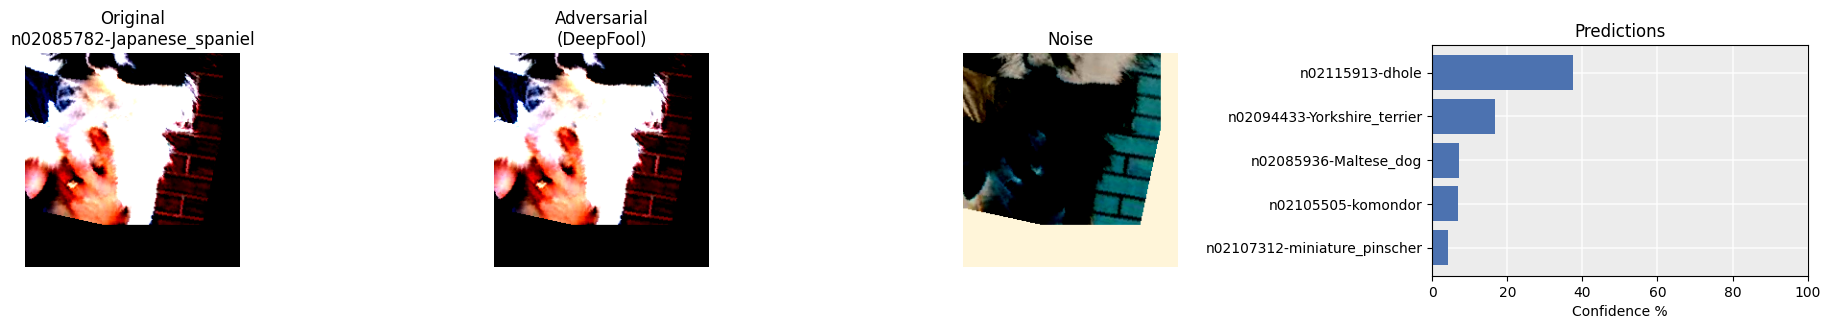

<ipython-input-7-c1adcf0c2471>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


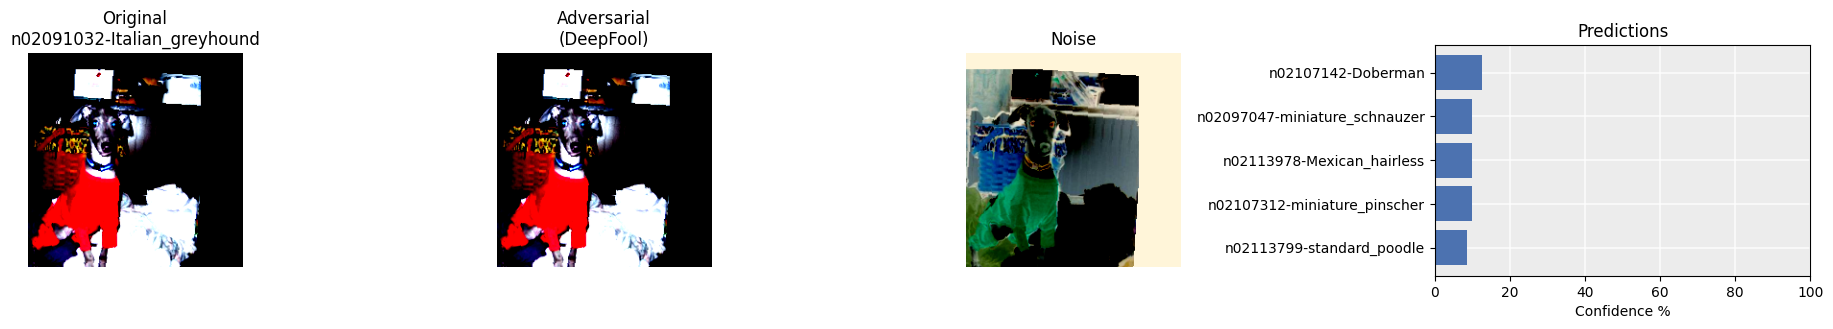

<ipython-input-7-c1adcf0c2471>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


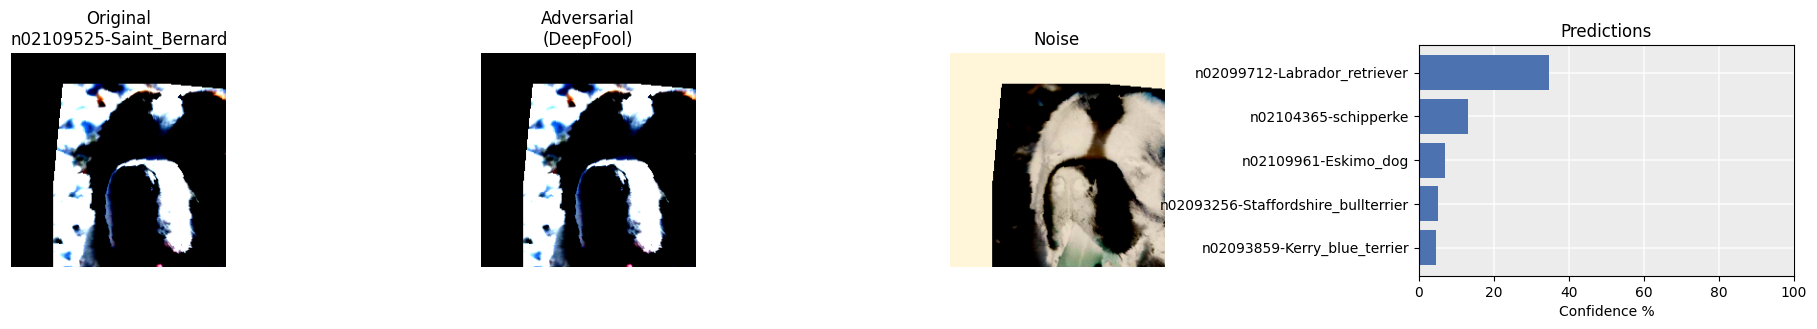

<ipython-input-7-c1adcf0c2471>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


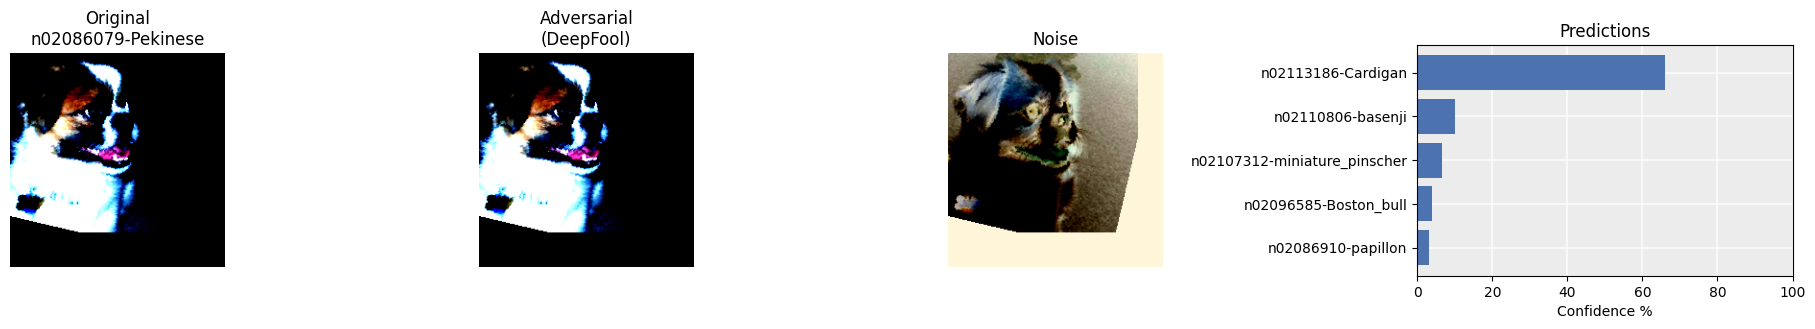

<ipython-input-7-c1adcf0c2471>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


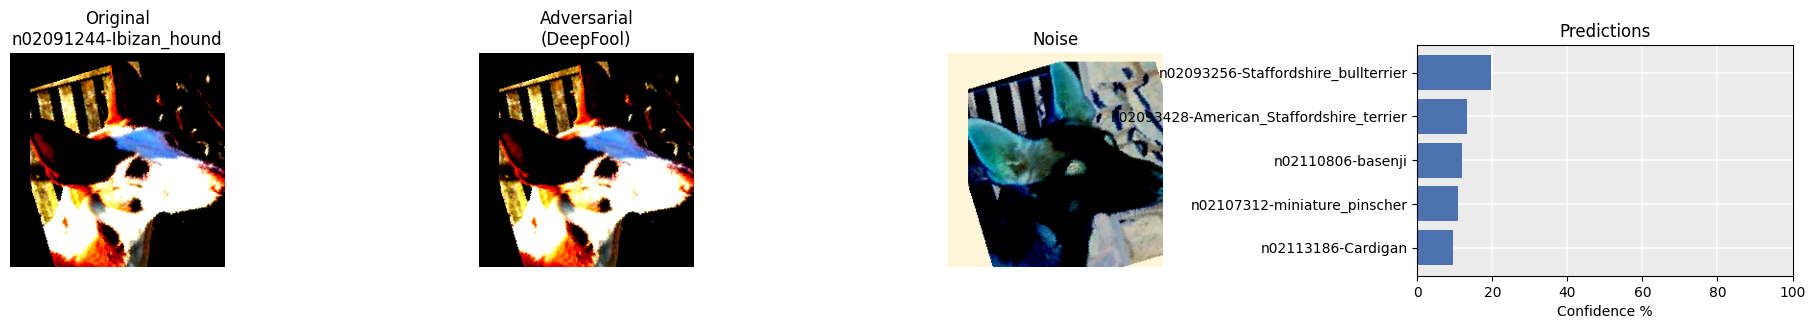

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def deepfool_attack(image, model, num_classes=10, overshoot=0.02, max_iter=50):
    """
    Perform the DeepFool attack to generate adversarial examples.
    """
    model.eval()
    image = image.unsqueeze(0).clone().detach().requires_grad_(True).to(next(model.parameters()).device)
    output = model(image)
    _, pred = torch.max(output, 1)
    original_label = pred.item()
    perturbation = torch.zeros_like(image).to(next(model.parameters()).device)

    for _ in range(max_iter):
        output = model(image + perturbation)
        probs = torch.softmax(output, dim=1)
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        if sorted_indices[0][0].item() != original_label:
            break
        grad_orig = torch.autograd.grad(output[0, original_label], image, retain_graph=True)[0]
        perturbation_direction = None
        min_perturbation = np.inf
        for k in range(1, num_classes):
            grad_other = torch.autograd.grad(output[0, sorted_indices[0][k]], image, retain_graph=True)[0]
            direction = grad_other - grad_orig
            delta = (output[0, sorted_indices[0][k]] - output[0, original_label]).abs() / direction.norm()
            if delta < min_perturbation:
                min_perturbation = delta
                perturbation_direction = direction
        perturbation += (min_perturbation + overshoot) * perturbation_direction / perturbation_direction.norm()

    adv_image = torch.clamp(image + perturbation, 0, 1).detach()
    return adv_image.squeeze(0), perturbation.squeeze(0)

def visualize_deepfool_attack(model, dataloader, class_names, device, num_images=5):
    """
    Visualize multiple images with adversarial examples and predictions.
    """
    model.eval()
    processed_images = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        for i in range(len(images)):
            if processed_images >= num_images:
                return

            original_image = images[i]
            original_label = labels[i].item()

            # Generate adversarial example
            adv_image, perturbation = deepfool_attack(original_image, model)

            # Get predictions for adversarial image
            outputs = model(adv_image.unsqueeze(0))
            pred_probs, pred_classes = torch.topk(torch.softmax(outputs, dim=1).squeeze(), 5)

            # Convert tensors to NumPy for visualization
            original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
            adv_image_np = adv_image.permute(1, 2, 0).cpu().numpy()
            noise_np = (adv_image - original_image).permute(1, 2, 0).cpu().numpy()

            # Plot the results
            fig, axes = plt.subplots(1, 4, figsize=(23, 3), gridspec_kw={'width_ratios': [2, 2, 2, 3.5], 'wspace': 1})

            # Original Image
            axes[0].imshow(original_image_np)
            axes[0].set_title(f'Original\n{class_names[original_label]}')
            axes[0].axis('off')

            # Adversarial Image
            axes[1].imshow(adv_image_np)
            axes[1].set_title(f'Adversarial\n(DeepFool)')
            axes[1].axis('off')

            # Noise
            axes[2].imshow(noise_np / noise_np.max())
            axes[2].set_title('Noise')
            axes[2].axis('off')

            # Prediction Bar Chart
            axes[3].barh(np.arange(5), pred_probs.detach().cpu().numpy() * 100,
                         color=['#55A868' if class_names[pred_classes[j]] == class_names[original_label] else '#4C72B0' for j in range(5)])
            axes[3].set_yticks(np.arange(5))
            axes[3].set_yticklabels([class_names[pred_classes[j]] for j in range(5)])
            axes[3].invert_yaxis()
            axes[3].set_xlabel('Confidence %')
            axes[3].set_title('Predictions')
            axes[3].set_xlim(0, 100)
            axes[3].set_facecolor('#ECECEC')
            axes[3].xaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
            axes[3].yaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
            axes[3].set_axisbelow(True)

            plt.tight_layout()
            plt.show()

            processed_images += 1

# Example Usage
# Assuming 'model', 'test_loader', 'class_names', and 'device' are already defined
visualize_deepfool_attack(model, val_dataloader, class_names, device, num_images=5)


6)Adversarial Training Implementation:

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

def deepfool_attack_batch(images, labels, model, num_classes=10, overshoot=0.02, max_iter=1):
    """
    Perform DeepFool attack on a batch of images, generating adversarial examples.
    """
    model.eval()
    adv_images = images.clone().detach().to(next(model.parameters()).device)
    batch_size = images.size(0)
    perturbations = torch.zeros_like(adv_images)

    for i in range(batch_size):
        image = images[i].unsqueeze(0).clone().detach().requires_grad_(True)
        label = labels[i]
        perturbation = torch.zeros_like(image).to(next(model.parameters()).device)

        for _ in range(max_iter):
            output = model(image + perturbation)
            probs = torch.softmax(output, dim=1)
            _, pred = torch.max(probs, 1)
            if pred.item() != label.item():  # If misclassified, stop early
                break

            grad_orig = torch.autograd.grad(output[0, label], image, retain_graph=True)[0]
            min_perturbation = float("inf")
            perturbation_direction = None

            for k in range(num_classes):
                if k == label.item():
                    continue
                grad_other = torch.autograd.grad(output[0, k], image, retain_graph=True)[0]
                direction = grad_other - grad_orig
                delta = abs(output[0, k] - output[0, label]) / direction.norm()
                if delta < min_perturbation:
                    min_perturbation = delta
                    perturbation_direction = direction

            if perturbation_direction is not None:
                perturbation += (min_perturbation + overshoot) * perturbation_direction / perturbation_direction.norm()

        adv_images[i] = torch.clamp(image + perturbation, 0, 1).squeeze(0)

    return adv_images

def adversarial_training(model, train_loader, device, num_epochs=1, lr=0.001):
    """
    Perform adversarial training on the model using DeepFool attack.
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Generate adversarial examples using DeepFool
            adv_images = deepfool_attack_batch(images, labels, model)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass with adversarial examples
            outputs = model(adv_images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Print epoch statistics
        epoch_accuracy = correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Example usage
# Assuming 'train_loader', 'model', and 'device' are defined
adversarial_training(model, train_dataloader, device, num_epochs=1)


Epoch [1/1], Loss: 3380.5734, Accuracy: 0.2755


7)Adversarial Attack Implementation After Adversarial Training:


<ipython-input-14-301ac5c01691>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


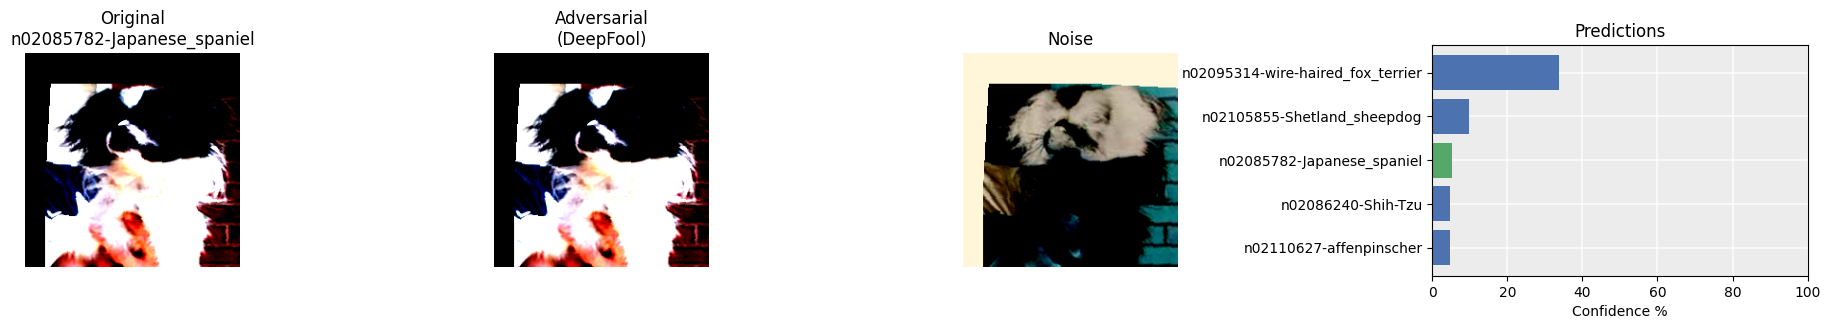

<ipython-input-14-301ac5c01691>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


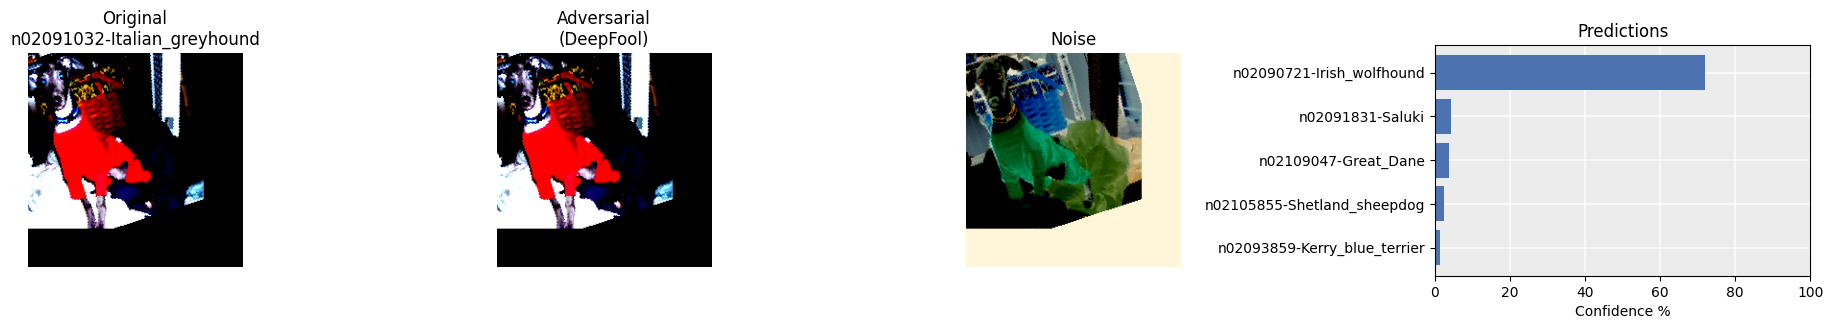

<ipython-input-14-301ac5c01691>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


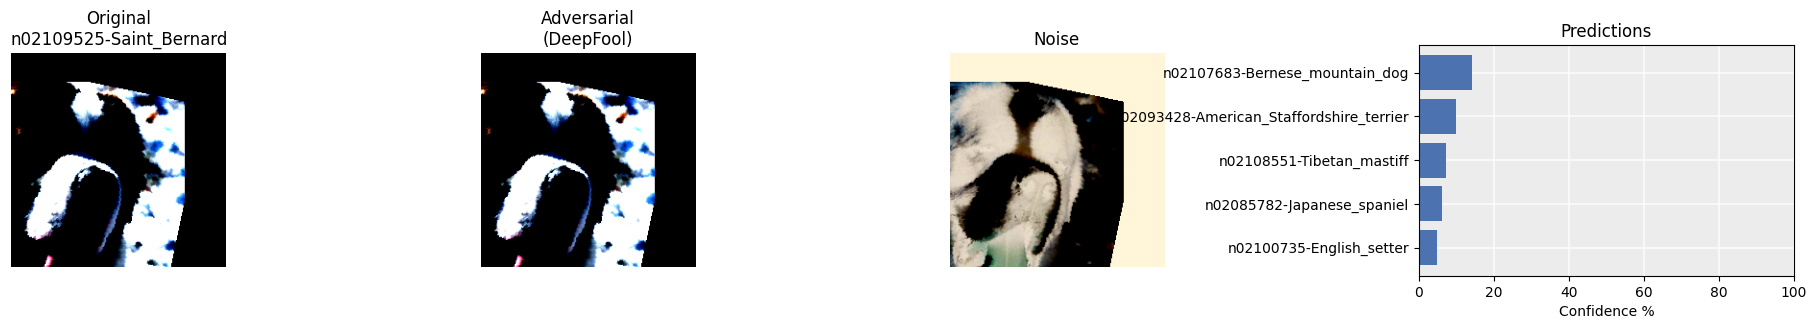

Adversarial Evaluation Results (DeepFool Attack):
Accuracy: 0.3750


In [14]:
def evaluate_adversarial_attack_visual(model, dataloader, class_names, device, num_classes=10, attack="DeepFool", max_iter=1, max_batches=3):
    """
    Evaluate the adversarially trained model under adversarial attack with visualizations.
    """
    model.eval()
    correct = 0
    total = 0
    processed_images = 0
    max_visualizations = 3  # Visualize results for at least 3 images
    processed_batches = 0  # Track the number of processed batches

    for images, labels in dataloader:
        if processed_batches >= max_batches:
            break  # Stop after processing the specified number of batches

        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples using DeepFool
        adv_images = deepfool_attack_batch(images, labels, model, num_classes=num_classes, max_iter=max_iter)

        # Get predictions on adversarial examples
        outputs = model(adv_images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Visualize the first few images
        for i in range(len(images)):
            if processed_images >= max_visualizations:
                break

            original_img_np = tensor_to_img(images[i])  # Convert original image to NumPy
            adv_img_np = tensor_to_img(adv_images[i])  # Convert adversarial image to NumPy
            noise_img_np = tensor_to_img(adv_images[i] - images[i])  # Convert noise to NumPy

            # Get predictions for visualization
            outputs = model(adv_images[i].unsqueeze(0))
            pred_probs, pred_classes = torch.topk(torch.softmax(outputs, dim=1).squeeze(), 5)

            # Plot the results
            fig, axes = plt.subplots(1, 4, figsize=(23, 3), gridspec_kw={'width_ratios': [2, 2, 2, 3.5], 'wspace': 1})

            # Original Image
            axes[0].imshow(original_img_np)
            axes[0].set_title(f'Original\n{class_names[labels[i]]}')
            axes[0].axis('off')

            # Adversarial Image
            axes[1].imshow(adv_img_np)
            axes[1].set_title(f'Adversarial\n({attack})')
            axes[1].axis('off')

            # Noise
            axes[2].imshow(noise_img_np / np.abs(noise_img_np).max())
            axes[2].set_title('Noise')
            axes[2].axis('off')

            # Prediction Bar Chart
            axes[3].barh(np.arange(5), pred_probs.detach().cpu().numpy() * 100,
                        color=['#55A868' if class_names[pred_classes[j]] == class_names[labels[i]] else '#4C72B0' for j in range(5)])
            axes[3].set_yticks(np.arange(5))
            axes[3].set_yticklabels([class_names[pred_classes[j]] for j in range(5)])
            axes[3].invert_yaxis()
            axes[3].set_xlabel('Confidence %')
            axes[3].set_title('Predictions')
            axes[3].set_xlim(0, 100)
            axes[3].set_facecolor('#ECECEC')
            axes[3].xaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
            axes[3].yaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
            axes[3].set_axisbelow(True)

            plt.tight_layout()
            plt.show()

            processed_images += 1

        processed_batches += 1  # Increment processed batch counter

    # Print overall evaluation results
    accuracy = correct / total if total > 0 else 0
    print(f"Adversarial Evaluation Results ({attack} Attack):")
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# Example Usage
# Assuming 'val_loader', 'model', 'class_names', and 'device' are already defined
adv_accuracy = evaluate_adversarial_attack_visual(
    model, val_dataloader, class_names, device, num_classes=10, attack="DeepFool", max_iter=1, max_batches=3
)


In [9]:
'''
def calculate_accuracy_deepfool(model, dataloader, device, class_names, num_classes=120, adversarial=False):
    """
    Evaluate the model accuracy on clean or adversarial (DeepFool) data.
    :param model: The trained model.
    :param dataloader: DataLoader for the dataset to evaluate.
    :param device: Device to run the evaluation (CPU or GPU).
    :param class_names: List of class names.
    :param num_classes: Number of classes for the classifier.
    :param adversarial: If True, apply DeepFool attack to create adversarial examples.
    """
    model.eval()
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        if adversarial:
            # Generate DeepFool adversarial examples
            adv_images = []
            for img in images:
                adv_img, _ = deepfool_attack(img, model, num_classes=num_classes)
                adv_images.append(adv_img)
            images = torch.stack(adv_images)

        # Get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total * 100
    print(f"{'Adversarial' if adversarial else 'Clean'} Accuracy: {accuracy:.2f}%")
    return accuracy

# Example Usage model, val_dataloader, class_names, device
clean_accuracy = calculate_accuracy_deepfool(model, val_dataloader, device, class_names, adversarial=False)
adversarial_accuracy = calculate_accuracy_deepfool(model, val_dataloader, device, class_names, adversarial=True)

'''



def calculate_accuracy_deepfool(model, dataloader, device, class_names, num_classes=120, adversarial=False, max_iter=5):
    """
    Evaluate the model accuracy on clean or adversarial (DeepFool) data with reduced iterations.
    :param model: The trained model.
    :param dataloader: DataLoader for the dataset to evaluate.
    :param device: Device to run the evaluation (CPU or GPU).
    :param class_names: List of class names.
    :param num_classes: Number of classes for the classifier.
    :param adversarial: If True, apply DeepFool attack to create adversarial examples.
    :param max_iter: Maximum iterations for DeepFool attack (default=5 for reduced runtime).
    """
    model.eval()
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        if adversarial:
            # Generate DeepFool adversarial examples with reduced iterations
            adv_images = []
            for img in images:
                adv_img, _ = deepfool_attack(img, model, num_classes=num_classes, max_iter=max_iter)  # Reduced iterations
                adv_images.append(adv_img)
            images = torch.stack(adv_images)

        # Get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total * 100
    print(f"{'Adversarial' if adversarial else 'Clean'} Accuracy: {accuracy:.2f}%")
    return accuracy

# Example Usage
clean_accuracy = calculate_accuracy_deepfool(
    model, val_dataloader, device, class_names, adversarial=False
)

adversarial_accuracy = calculate_accuracy_deepfool(
    model, val_dataloader, device, class_names, adversarial=True, max_iter=5  # Reduced iterations
)


Clean Accuracy: 81.51%


KeyboardInterrupt: 